# Generalised Huckel Solver

> Constructs the Huckel matrix and solves for the values, based on Ex 3.1 instructions

This solver will only work if all $p$ orbitals are equivalent (it will not consider for instance perturbations due to nitrogen in pyridine).
The Huckel theory assumptions are:
$$ H_{ij}= \begin{cases} \alpha,\  i=j\\ \beta,\  i \text{ adjacent to } j\\ 0,\  \text{otherwise}\end{cases} $$
with scaling such that $\alpha = 0$ and $\beta =-1$. As such, it can be seen that the resulting Huckel matrix is the negative of the adjacency matrix $A$ where: 
$$ A_{ij}= \begin{cases}  1,\  i \text{ adjacent to } j\\ 0,\  \text{otherwise}\end{cases} $$

In [ ]:
#| default_exp huckel

In [ ]:
#| export
#| echo: false
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from IPython.display import SVG, Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| export
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
IPythonConsole.drawOptions.addAtomIndices = True

In [ ]:
#| export
def generate_smiles(l_or_r:str, # linear or ring
                    n:int     # the number of atoms in the molecule
                    ):
    """
    generate the smiles of either a straight chain or ring polyene, with n atoms.
    All carbons will be sp2 hybridised.
    For linear molecules with an odd number of atoms it will return the anion
    For rings with 4n+1 atoms it will return the anion eg C5H5-
    For rings with 4n+3 atoms it will return the cation eg C7H7+
    """
    unit = 'C=C' # the base 2 carbon double bond unit
    if n<3: l_or_r = 'linear' #ring needs at least 3 atoms
    if n <=1:
        raise Exception("More than 1 Carbon atoms is needed")
    if not isinstance(n, int):
        raise Exception("An integer number of atoms is needed")
    if l_or_r == 'linear':
        repeats = n//2 # repeats of the base unit of 2 carbons
        terminal = n%2 # whether or not a terminal carbon is needed
        output = repeats*unit +terminal*"[CH2+]"
    if l_or_r == 'ring':
        repeats = n//2 # repeats of the base unit of 2 carbons
        cation_terminal = 1 if n%4==3 else 0 # if 4n+3 carbon atoms: cation eg C7H7+
        anion_terminal = 1 if n%4==1 else 0 # if 4n+3 carbon atoms: cation eg C5H5-
        output = "C1=C" +(repeats-1)*unit +anion_terminal*"[CH-]"+cation_terminal*"[CH+]"+"1"
    return output

In [ ]:
#| export
def Huckel_solve(matrix):
    """
    From a Huckel matrix input, solve for the Huckel pi system
    Returns a dictionary of energy levels with the associated (possibly degenerate) wavefunctions
    """
    vals, vecs = np.linalg.eig(matrix)
    # create dictionary where each eigenvalue has a list of the associated eigenvectors
    energy_dict = {}
    for i, val in enumerate(vals):
        # pythons eigenvalues sometimes produce rounding errors at the 14th dp: eg eigenvalues for benzene being 1.0 and 0.9999999999999998
        # similarly, trivial imaginary parts are occasionally produced: on the order of 10^-16 i
        val = round(np.real(val), 3)
        if val in energy_dict:
            energy_dict[val].append(vecs[:,i])
        else: energy_dict[val]=[vecs[:,i]]
    return energy_dict

In [ ]:
#| export
class Huckel:
    """The solution to the Huckel equation for a molecule given as SMILES"""
    def __init__(self, SMILES:str="c1ccccc1"):
        self.smiles = SMILES
        self.molecule = Chem.MolFromSmiles(SMILES)
        self.matrix = -Chem.GetAdjacencyMatrix(self.molecule)

    @property
    def energy_dict(self):
        return Huckel_solve(self.matrix)
    @energy_dict.setter
    def energy_dict(self, value):
        raise Exception("Energy is determined by Huckel matrix and so read only")

    def plot(self):
        """
        Plots an MO diagram based on a dictionary of energy levels and associated wavefunctions
        """
        fig, ax = plt.subplots()
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        for level in self.energy_dict:
            degeneracy = len(self.energy_dict[level])
            x = np.arange(-(0.5*(degeneracy - 1)),(0.5*(degeneracy)), 1)
            y = [level]*(degeneracy)
            ax.scatter(x, y, s =900, marker = '_', linewidth = 3)
        plt.show()
    def __str__(self):
        string = 'Huckel Energies (degeneracy) for ' +self.smiles +':'
        for level in dict(sorted(self.energy_dict.items())): #this sorts the energy levels in order from lowest to highest
            degeneracy = len(self.energy_dict[level])
            string = string + " [%.3f (%d)] " % (level, degeneracy)
        return string

This works in a straightforward manner for chains and rings

Huckel Energies (degeneracy) for C=CC=CC=CC=CC=C: [-1.919 (1)]  [-1.683 (1)]  [-1.310 (1)]  [-0.831 (1)]  [-0.285 (1)]  [0.285 (1)]  [0.831 (1)]  [1.310 (1)]  [1.683 (1)]  [1.919 (1)] 


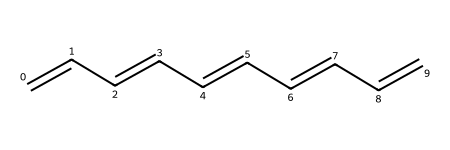

In [ ]:
mol = generate_smiles('linear', 10)
mol = Huckel(mol)
print(mol)
mol.molecule

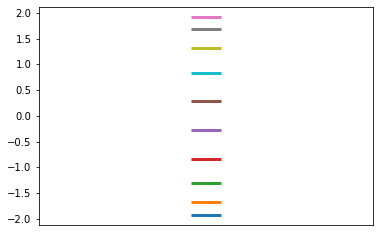

In [ ]:
mol.plot()

Huckel Energies (degeneracy) for C1=CC=CC=C1: [-2.000 (1)]  [-1.000 (2)]  [1.000 (2)]  [2.000 (1)] 


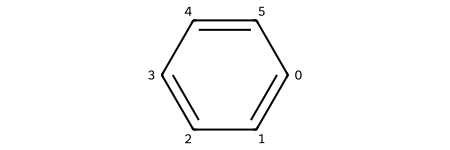

In [ ]:
mol = generate_smiles('ring', 6)
mol = Huckel(mol)
print(mol)
mol.molecule

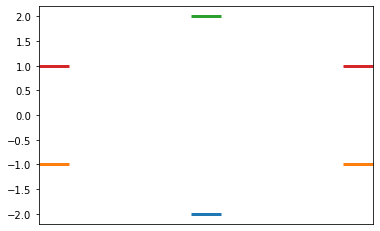

In [ ]:
mol.plot()

Similarly, it works for more complkex 3d structures (though rdkit struggles to show their structure in the output skeletal diagram)

In [ ]:
tetrahedrane_smiles = 'C12C3C1C23'
cubane_smiles = 'C12C3C4C1C5C2C3C45'
dodecahedrane_smiles = 'C12C3C4C5C1C6C7C2C8C3C9C4C1C5C6C2C7C8C9C12'
fullerene_smiles = "c12c3c4c5c2c2c6c7c1c1c8c3c3c9c4c4c%10c5c5c2c2c6c6c%11c7c1c1c7c8c3c3c8c9c4c4c9c%10c5c5c2c2c6c6c%11c1c1c7c3c3c8c4c4c9c5c2c2c6c1c3c42"

In [ ]:
# rdkit does consider all bonds, even if all are not shown on the output skeletal diagram: this is mostly apparent for cubane
molecule = Chem.MolFromSmiles(cubane_smiles)
mat = -Chem.GetAdjacencyMatrix(molecule)
print(mat)

[[ 0 -1  0 -1  0 -1  0  0]
 [-1  0 -1  0  0  0 -1  0]
 [ 0 -1  0 -1  0  0  0 -1]
 [-1  0 -1  0 -1  0  0  0]
 [ 0  0  0 -1  0 -1  0 -1]
 [-1  0  0  0 -1  0 -1  0]
 [ 0 -1  0  0  0 -1  0 -1]
 [ 0  0 -1  0 -1  0 -1  0]]


Huckel Energies (degeneracy) for C12C3C1C23: [-3.000 (1)]  [1.000 (3)] 


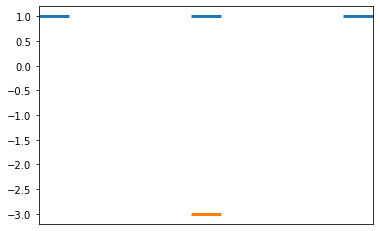

In [ ]:
tetrahedrane = Huckel(tetrahedrane_smiles)
print(tetrahedrane)
tetrahedrane.plot()

Huckel Energies (degeneracy) for C12C3C4C1C5C2C3C45: [-3.000 (1)]  [-1.000 (3)]  [1.000 (3)]  [3.000 (1)] 


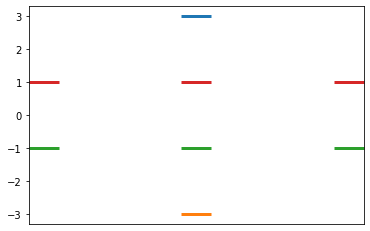

In [ ]:
cubane = Huckel(cubane_smiles)
print(cubane)
cubane.plot()

Huckel Energies (degeneracy) for C12C3C4C5C1C6C7C2C8C3C9C4C1C5C6C2C7C8C9C12: [-3.000 (1)]  [-2.236 (3)]  [-1.000 (5)]  [0.000 (4)]  [2.000 (4)]  [2.236 (3)] 


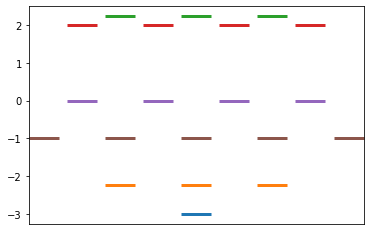

In [ ]:
dodecahedrane = Huckel(dodecahedrane_smiles)
print(dodecahedrane)
dodecahedrane.plot()

Huckel Energies (degeneracy) for c12c3c4c5c2c2c6c7c1c1c8c3c3c9c4c4c%10c5c5c2c2c6c6c%11c7c1c1c7c8c3c3c8c9c4c4c9c%10c5c5c2c2c6c6c%11c1c1c7c3c3c8c4c4c9c5c2c2c6c1c3c42: [-3.000 (1)]  [-2.757 (3)]  [-2.303 (5)]  [-1.820 (3)]  [-1.562 (4)]  [-1.000 (9)]  [-0.618 (5)]  [0.139 (3)]  [0.382 (3)]  [1.303 (5)]  [1.438 (3)]  [1.618 (5)]  [2.000 (4)]  [2.562 (4)]  [2.618 (3)] 


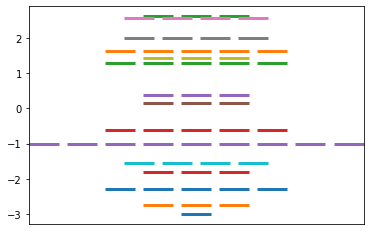

In [ ]:
fullerene = Huckel(fullerene_smiles)
print(fullerene)
fullerene.plot()

It is also possible to manually overwrite the Huckel matrix in order to deal with species such as pyridine:

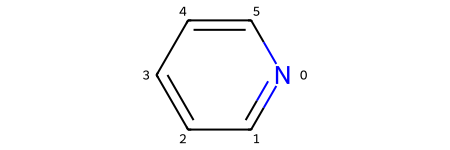

In [ ]:
pyridine = Huckel('n1ccccc1')
pyridine.molecule

The Huckel matrix at the moment is still only the negative of the adjacency matrix, and so is the same as that of benzene

In [ ]:
pyridine.matrix

array([[ 0, -1,  0,  0,  0, -1],
       [-1,  0, -1,  0,  0,  0],
       [ 0, -1,  0, -1,  0,  0],
       [ 0,  0, -1,  0, -1,  0],
       [ 0,  0,  0, -1,  0, -1],
       [-1,  0,  0,  0, -1,  0]], dtype=int32)

We can overwrite this matrix: taking the assumption in the A4 course, that $\alpha_{N} = \alpha+\beta/2$ and $\beta_{NC}=0.8\beta$

In [ ]:
pyridine.matrix = np.array([[ -1/2, -0.8,  0,  0,  0, -0.8],
       [-0.8,  0, -1,  0,  0,  0],
       [ 0, -1,  0, -1,  0,  0],
       [ 0,  0, -1,  0, -1,  0],
       [ 0,  0,  0, -1,  0, -1],
       [-0.8,  0,  0,  0, -1,  0]])

Huckel Energies (degeneracy) for n1ccccc1: [-1.954 (1)]  [-1.062 (1)]  [-1.000 (1)]  [0.667 (1)]  [1.000 (1)]  [1.849 (1)] 


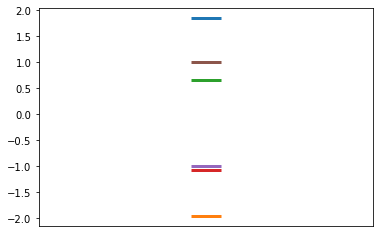

In [ ]:
print(pyridine)
pyridine.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()